# 2D Distance Properties Plots

### Importing Tables

In [19]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt


import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import binned_statistic

import seaborn as sns

import statsmodels.api as sm

from scipy import stats

#HyperFit

import sys 
sys.path.insert(1, r"C:\Users\caeho\OneDrive\Documents\University of Rochester REU\HyperFit\src")
from hyperfit.linfit import LinFit



ModuleNotFoundError: No module named 'snowline'

In [2]:
dwarf_table = Table.read('dwarf_table.txt', format = 'ascii.commented_header')
dwarf_table[:5]

aimc,IN_DR7_LSS,RA,DEC,Z,ELPETRO_ABSMAG_r,u_r,sSFR,HImass,flag3727,t3,Z12logOH,Zerr,logNO,NOerr,vflag_VF,ID,BPTclass,2D_neighbor_ID,2D_neighbor_dist,2D_neighbor_ID_vir,2D_neighbor_dist_vir,3D_neighbor_ID,3D_neighbor_dist,3D_neighbor_ID_vir,3D_neighbor_dist_vir
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64
0.0,1.0,147.17645340393182,-0.3540349522432606,0.006282840855419636,-15.534673690795898,1.5979467332363129,-9.897252082824707,nan,nan,nan,nan,nan,nan,nan,2,12,1.0,49,0.18150554228021565,585714,1.3634632510011546,573,0.3210655024172438,208,2.3657856725525463
106.68,1.0,146.85676432411947,-0.27409664376066756,0.02196459472179413,-16.7003231048584,1.6220477223396301,-9.639364242553711,nan,nan,nan,nan,nan,nan,nan,2,31,1.0,79,0.6704515586457357,92,2.414294367856323,80,0.9556330809587631,585700,3.7385754919749274
0.0,1.0,146.19277353258968,-0.6882589506846374,0.004080323036760092,-15.290872573852539,1.220979243516922,-9.548693656921387,nan,nan,nan,nan,nan,nan,nan,2,44,1.0,585695,0.035663331434249095,639857,0.46035331496314846,585695,0.221530846641702,585695,2.8927174640703734
199.39,1.0,146.00780426178756,-0.6422574964819474,0.004776299931108952,-15.831652641296387,0.7728094607591629,-7.982375621795654,nan,0.0,1.5717060395681055,7.73051787768279,0.0179600111522654,-0.5320566539047968,0.44255404846002694,2,45,1.0,585695,0.006393284307917346,585695,0.08348257342324528,639857,0.6010801341408164,639857,7.109919536505821
0.0,1.0,146.6190367018052,-0.43434631860351913,0.006036635022610426,-16.34455108642578,1.7559601366519928,-9.769034385681152,nan,nan,nan,nan,nan,nan,nan,2,49,1.0,585714,0.07059729101415332,585714,0.4172620229334301,585714,0.3596492056527832,585714,2.125689993784549


In [17]:
errors_table = Table.read('errors_CMD_table.txt', format = 'ascii.commented_header')
errors_table[:5]

u_r_err,sSFR_err,CMD_class,ELPETRO_AMIVAR_r,ID
float64,float64,int64,float64,int64
0.019882047548890114,nan,-99,2487.77734375,0
0.19388361275196075,1.169804573059082,2,2198.116455078125,1
0.1018315926194191,nan,-99,1406.6728515625,2
0.22052867710590363,1.3031730651855469,3,128.3397674560547,3
0.22563263773918152,nan,-99,1161.7567138671875,4


In [20]:
dwarf_table = join(dwarf_table, errors_table, join_type = 'left', keys = 'ID')

In [21]:
dwarf_table

aimc,IN_DR7_LSS,RA,DEC,Z,ELPETRO_ABSMAG_r,u_r,sSFR,HImass,flag3727,t3,Z12logOH,Zerr,logNO,NOerr,vflag_VF,ID,BPTclass,2D_neighbor_ID,2D_neighbor_dist,2D_neighbor_ID_vir,2D_neighbor_dist_vir,3D_neighbor_ID,3D_neighbor_dist,3D_neighbor_ID_vir,3D_neighbor_dist_vir,u_r_err,sSFR_err,CMD_class,ELPETRO_AMIVAR_r
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,float64,float64,int64,float64
0.0,1.0,147.17645340393182,-0.3540349522432606,0.006282840855419636,-15.534673690795898,1.5979467332363129,-9.897252082824707,nan,nan,nan,nan,nan,nan,nan,2,12,1.0,49,0.18150554228021565,585714,1.3634632510011546,573,0.3210655024172438,208,2.3657856725525463,0.08410719037055969,0.5447912216186523,2,1759.3416748046875
106.68,1.0,146.85676432411947,-0.27409664376066756,0.02196459472179413,-16.7003231048584,1.6220477223396301,-9.639364242553711,nan,nan,nan,nan,nan,nan,nan,2,31,1.0,79,0.6704515586457357,92,2.414294367856323,80,0.9556330809587631,585700,3.7385754919749274,0.1891634464263916,0.5290708541870117,1,705.89501953125
0.0,1.0,146.19277353258968,-0.6882589506846374,0.004080323036760092,-15.290872573852539,1.220979243516922,-9.548693656921387,nan,nan,nan,nan,nan,nan,nan,2,44,1.0,585695,0.035663331434249095,639857,0.46035331496314846,585695,0.221530846641702,585695,2.8927174640703734,0.04690810292959213,0.8169212341308594,1,1947.9483642578125
199.39,1.0,146.00780426178756,-0.6422574964819474,0.004776299931108952,-15.831652641296387,0.7728094607591629,-7.982375621795654,nan,0.0,1.5717060395681055,7.73051787768279,0.0179600111522654,-0.5320566539047968,0.44255404846002694,2,45,1.0,585695,0.006393284307917346,585695,0.08348257342324528,639857,0.6010801341408164,639857,7.109919536505821,0.010177218355238438,0.38345956802368164,1,2423.86083984375
0.0,1.0,146.6190367018052,-0.43434631860351913,0.006036635022610426,-16.34455108642578,1.7559601366519928,-9.769034385681152,nan,nan,nan,nan,nan,nan,nan,2,49,1.0,585714,0.07059729101415332,585714,0.4172620229334301,585714,0.3596492056527832,585714,2.125689993784549,0.037948835641145706,0.5800094604492188,1,2307.06201171875
21.37,1.0,146.28299647851426,0.0641463074401177,0.021579895168542862,-16.594152450561523,2.861306369304657,-10.189197540283203,nan,nan,nan,nan,nan,nan,nan,2,91,1.0,80,0.038323438909891316,92,0.17226127693210824,92,0.10268810550034341,92,0.3052372880294029,0.3047657012939453,0.5753030776977539,2,1595.2012939453125
0.0,1.0,145.3209420527222,0.771115298508063,0.00658948952332139,-14.810564994812012,1.925416886806488,-9.748167991638184,nan,0.0,3.57494352664153,7.007952737418975,0.2935407103312847,-0.9956427104372425,0.4090425521885854,2,186,1.0,208,0.16133006586884238,208,0.576340261650062,208,0.6516081633066332,208,2.3278241244801396,0.09068658947944641,0.44332408905029297,2,1937.6204833984375
-99.0,1.0,145.4212238164792,0.5359777701124617,0.1459859162569046,-14.866592407226562,-3.4473413228988647,nan,nan,nan,nan,nan,nan,nan,nan,9,209,nan,206,0.23624643923335842,206,0.5428900018158784,206,0.53709656480362,206,1.2342380947105809,30.633142471313477,nan,-99,0.0
0.0,1.0,146.26576246056774,1.2304320197663696,0.006355164106935263,-14.2352876663208,1.6930833458900452,-9.700735092163086,nan,0.0,4.040375795270858,7.048466376827344,0.3785143362106475,-1.2323400004904403,0.5170923842950506,2,238,1.0,55137,0.13915957213413985,55243,0.8924983833408165,55137,0.18685834815465546,208,1.4133282793228592,0.14035305380821228,0.8864994049072266,1,200.1648712158203


In [3]:
# gal_table = Table.read('gal_table.txt', format = 'ascii.commented_header')
# gal_table[:5]

In [ ]:
cmd_values = Table.read('errors_CMD_table.txt', format = 'ascii.commented_header')
cmd_values[:5]

In [ ]:
dwarf_table = join(dwarf_table, cmd_values, join_type='left', keys='ID')

In [ ]:
dwarf_table

## Getting values for Difference in Metallicity and N/O Ratio (Target - Neighboring)

In [4]:
t3mask = dwarf_table['t3'] < 3  # Makes a boolean selection mask (numpy array)
dwarf_t3= dwarf_table[t3mask]

In [5]:
#creating the new columns
dwarf_t3['2D_Z12logOH_diff'] = np.nan
dwarf_t3['2D_logNO_diff'] = np.nan

In [7]:
# for i in range(len(dwarf_t3)):
    
#     di = gal_table['ID#'] == dwarf_t3['2D_neighbor_ID'][i] #finding 2D neighboring galaxy in the large table
    
#     dwarf_t3['2D_Z12logOH_diff'][i] = dwarf_t3['Z12logOH'][i] - gal_table['Z12logOH'][di]
#     dwarf_t3['2D_logNO_diff'][i] = dwarf_t3['logNO'][i] - gal_table['logNO'][di]

In [8]:
# Separating into Void, Wall, or Other Dwarf Galaxies

dwarf_wall = dwarf_table['vflag_VF']==0
dwarf_void = dwarf_table['vflag_VF']==1
dwarf_other = ~(dwarf_wall | dwarf_void)


dwarf_wall_t3 = dwarf_t3['vflag_VF']==0
dwarf_void_t3 = dwarf_t3['vflag_VF']==1
dwarf_other_t3 = ~(dwarf_wall_t3 | dwarf_void_t3)

## Profile Histogram Function

In [223]:
def profilehist(x, y, w=None, bins=10, uncertainty='stderr'):
    """Compute a profile histogram given x, y and optional weights.
    
    Parameters
    ----------
    x : (N,) array_like
        Sequence of values to be binned.
    y : (N,) array_like
        Data on which the statistic will be computed.
    w : None or (N,) array_like
        Weights for each data point y.
    bins : int or array_like
        If int, define equal-length bins given by data min/max range; else, user-defined bin edges.
    uncertainty : str
        'stderr' to compute standard error on the mean; 'sample' for sample uncertainty
        
    Returns
    -------
    xc : array of dtype float
        Bin centers in x.
    yavg : array of dtype float
        Average in each bin.
    yerr : array of dtype float
        Uncertainty in each bin (sample error or error on the mean).
    """
    # Default to equal weights in each bin.
    if w is None:
        w = np.ones_like(y, dtype=np.float64)

    # Compute weighted sums and construct the weighted means and uncertainties.
    (Y, E, W), edges, idx = binned_statistic(x, [w*y, w*y**2, w], bins=bins, statistic='sum')
    yavg = Y/W
    ystd = np.sqrt(E/W - yavg**2)
    yerr = ystd/np.sqrt(W)

    # Compute bin centers.
    xc = 0.5*(edges[1:] + edges[:-1])
    
    if uncertainty == 'sample':
        return xc, yavg, ystd
    elif uncertainty == 'stderr':
        return xc, yavg, yerr
    else:
        raise ValueError(f'uncertainty={uncertainty} unknown; allowed: "stderr" and "sample"')

# Profile Historgrams and Linear Regressions

## Color (u-r)


### Profile Histogram

In [ ]:
sfd = dwarf_table['BPTclass'] == 1
sfd_t3 = dwarf_t3['BPTclass'] == 1

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)

plt.rcParams.update({'font.size': 14})

for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    gal_plt = dwarf_table[select & sfd]
    #gal_plt = dwarf_table[select]
    
    d = gal_plt['2D_neighbor_dist'] #dwarf_table['2D_neighbor_dist'][select & sfd]
    vals = gal_plt['u_r'] #dwarf_table['u_r'][select & sfd]
    nonan = ~np.isnan(vals)
    bins = np.linspace(0,1,31)
    

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=bins, uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 1], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)
    
    #smoothed = sm.nonparametric.lowess(vals, d, frac = 0.01, it=10)
    
    #ax.plot(smoothed[0], smoothed[1], c)

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='u-r', xlim=([0,1]), ylim=([-0.5,3]));
    ax.legend();

    fig.savefig('sfd_ur_2D_PH.png')
    #fig.savefig('ur_2D_PH.png')
    
    #print(len(d))

In [12]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_table['2D_neighbor_dist'][select & sfd]
    vals = dwarf_table['u_r'][select & sfd]
    
    #d = dwarf_table['2D_neighbor_dist'][select]
    #vals = dwarf_table['u_r'][select]
    
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.logspace(np.log10(0.01),np.log10(1),31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 1], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='u-r', xlim=([0.01,1]), ylim=([-0.5,3]));
    ax.set_xscale('log') #changing x axis to a logarithmic scale

    ax.legend();

    fig.savefig('sfd_ur_2D_PH_log.png')
    #fig.savefig('ur_2D_PH_log.png')

### Linear Regression

#### Fould the linear equation by following this code: https://www.reddit.com/r/learnpython/comments/ho60se/seaborn_regplot_with_linear_regression_equation/



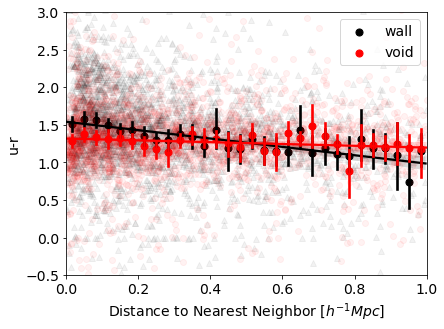

In [14]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)

plt.rcParams.update({'font.size': 14})
d_max = 1
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    #d_all = dwarf_table['2D_neighbor_dist'][select & sfd]
    #vals_all = dwarf_table['u_r'][select & sfd]
    
    d_all = dwarf_table['2D_neighbor_dist'][select]
    vals_all = dwarf_table['u_r'][select]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
        
        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='u-r', xlim=(0,1), ylim=(-0.5,3));
        
    ax.legend()
        
    #fig.savefig('sfd_ur_2D_LR.png')
    
    #fig.savefig('ur_2D_LR.png')

### Copy of above linear regression to test finding the linear regression equation

# Test code for Color Hyperfit plot 

In [209]:
#ndata = len(dwarf_table['u_r_err'])

#need to add something like this
'''mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    vals_err = vals_all_err[mask]'''

neigh_dist2d = dwarf_table[dwarf_wall]['2D_neighbor_dist'].value
u_r  = dwarf_table[dwarf_wall]['u_r'].value
du_r = dwarf_table[dwarf_wall]['u_r_err'].value

# Cut out the NaNs from the dwarf table.
select = ~np.isnan(u_r) & ~np.isnan(du_r) & (neigh_dist2d <= 1.)

neigh_dist2d = neigh_dist2d[select]
u_r  = u_r[select]
du_r = du_r[select]

#only look at values up to 1 Mpc/h (Do I need to add this?)
'''
mask = (neigh_dist2d > 0) & (neigh_dist2d <= 1)

neigh_dist2d = neigh_dist2d[mask]
u_r  = u_r[mask]
du_r = du_r[mask]
'''
    
ndata = len(u_r)
cov = np.empty((2, 2, ndata))
data = np.empty((2, ndata))

# Pack data into 2xN array and covariances into 2x2xN array.
for i, (_dist, _u_r, _du_r) in enumerate(zip(neigh_dist2d, u_r, du_r)):        
    data[0,i] = _dist
    data[1,i] = _u_r
    cov[:,:,i] = np.array([[0., 0.], [0., _du_r**2]])

In [210]:
len(du_r)

3080

In [211]:
np.sum(np.sqrt(cov[1,1]) / data[1] > 5)

38

#### Quick Sanity Check of the Data

Make sure the data are being packed correctly into the structures `data` and `cov`.

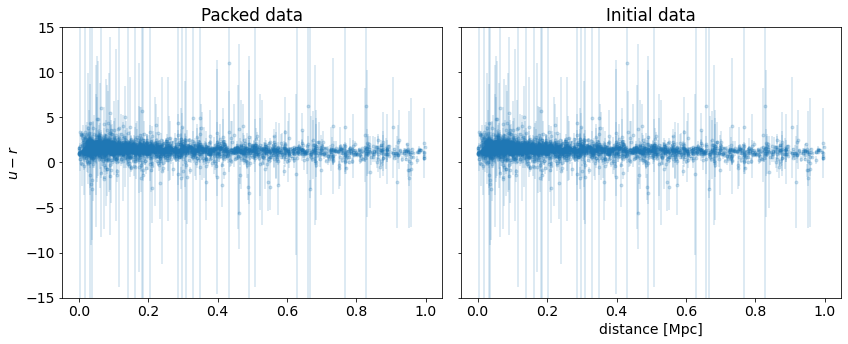

In [213]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.errorbar(data[0], data[1], yerr=np.sqrt(cov[1,1]), fmt='.', alpha=0.2)
ax.set(ylabel='$u-r$',
       title='Packed data')

ax = axes[1]
ax.errorbar(neigh_dist2d, u_r, yerr=du_r, fmt='.', alpha=0.2)
ax.set(xlabel='distance [Mpc]',
       title='Initial data',
       ylim=(-15,15));

#### Make Profile Histograms of the Selected Data

Text(0.5, 0, '$\\sigma_{u-r}/(u-r)$')

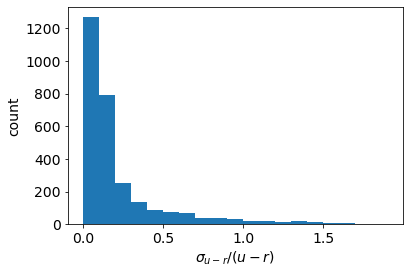

In [262]:
# Check distribution of relative uncertainties on u-r.
u_r_err_rel = du_r / np.abs(u_r)
plt.hist(u_r_err_rel, bins=np.arange(0, 2, 0.1))
plt.ylabel('count')
plt.xlabel(r'$\sigma_{u-r}/(u-r)$')

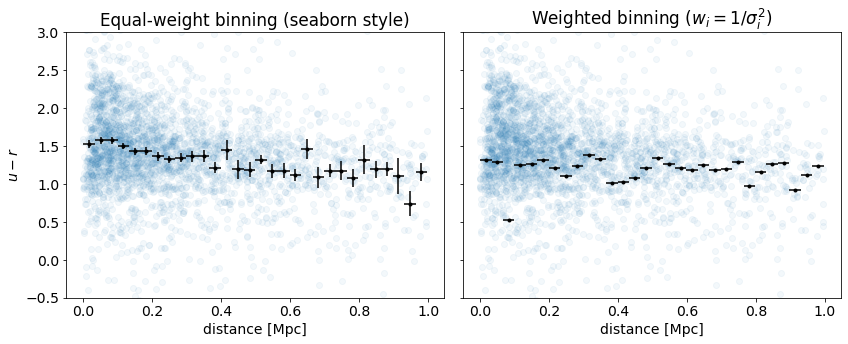

In [247]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
# dist, u_r_avg, u_r_err = profilehist(neigh_dist2d, u_r, w=1./du_r**2, bins=30, uncertainty='sample')
dist, u_r_avg, u_r_err = profilehist(neigh_dist2d, u_r, bins=30, uncertainty='stderr')
dist_err = 0.5*np.diff(dist)[0]
ax.scatter(neigh_dist2d, u_r, alpha=0.05)
ax.errorbar(dist, u_r_avg, xerr=dist_err, yerr=u_r_err, fmt='k.')
ax.set(ylim=(-0.5,3),
       ylabel='$u-r$',
       xlabel='distance [Mpc]',
       title='Equal-weight binning (seaborn style)')

ax = axes[1]
dist, u_r_avg, u_r_err = profilehist(neigh_dist2d, u_r, w=1./du_r**2, bins=30, uncertainty='stderr')
# dist, u_r_avg, u_r_err = profilehist(neigh_dist2d, u_r, bins=30, uncertainty='stderr')
dist_err = 0.5*np.diff(dist)[0]
ax.scatter(neigh_dist2d, u_r, alpha=0.05)
ax.errorbar(dist, u_r_avg, xerr=dist_err, yerr=u_r_err, fmt='k.')
ax.set(ylim=(-0.5,3),
       xlabel='distance [Mpc]',
       title=r'Weighted binning ($w_i=1/\sigma_i^2$)');

#### Try Cleaning to Keep Points with Small Relative Uncertainties

Keep only points with relative uncertainties below 10%.

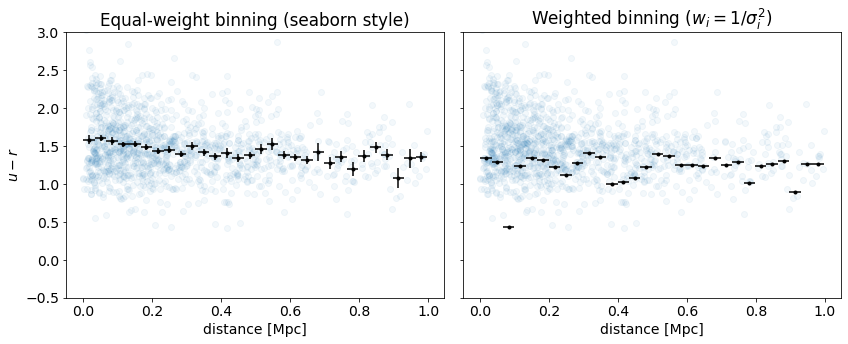

In [265]:
select = du_r / np.abs(u_r) < 0.1
neigh_dist2d_clean = neigh_dist2d[select]
u_r_clean = u_r[select]
du_r_clean = du_r[select]

fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
# dist, u_r_avg, u_r_err = profilehist(neigh_dist2d, u_r, w=1./du_r**2, bins=30, uncertainty='sample')
dist, u_r_avg, u_r_err = profilehist(neigh_dist2d_clean, u_r_clean, bins=30, uncertainty='stderr')
dist_err = 0.5*np.diff(dist)[0]
ax.scatter(neigh_dist2d_clean, u_r_clean, alpha=0.05)
ax.errorbar(dist, u_r_avg, xerr=dist_err, yerr=u_r_err, fmt='k.')
ax.set(ylim=(-0.5,3),
       ylabel='$u-r$',
       xlabel='distance [Mpc]',
       title='Equal-weight binning (seaborn style)')

ax = axes[1]
dist, u_r_avg, u_r_err = profilehist(neigh_dist2d_clean, u_r_clean, w=1./du_r_clean**2, bins=30, uncertainty='stderr')
# dist, u_r_avg, u_r_err = profilehist(neigh_dist2d, u_r, bins=30, uncertainty='stderr')
dist_err = 0.5*np.diff(dist)[0]
ax.scatter(neigh_dist2d_clean, u_r_clean, alpha=0.05)
ax.errorbar(dist, u_r_avg, xerr=dist_err, yerr=u_r_err, fmt='k.')
ax.set(ylim=(-0.5,3),
       xlabel='distance [Mpc]',
       title=r'Weighted binning ($w_i=1/\sigma_i^2$)');

### Attempt to Fit the Data with `hyperfit`

In [214]:
hf = LinFit(data, cov)
print(hf)

In [216]:
bounds = ((-10,10), (-10,10), (1e-5,5))
# bounds = ((-0.1,0.1), (-1,2), (1e-5,5))
result = hf.optimize(bounds, verbose=True)
result

     fun: array([-2837.02926192])
     jac: array([0.33192009, 0.15265869, 1.48661457])
 message: 'Optimization terminated successfully.'
    nfev: 2090
     nit: 45
 success: True
       x: array([0.36685622, 0.02253471, 0.23145378])


(array([-16.27961021,   5.99481099]), 3.7766123018049695, 2837.029261918568)

In [217]:
#bounds = ((-1,1), (1,2), (1e-5,5))
#bounds = ((-10.0, 10.0), (-1000.0, 1000.0), (1.0e-5, 500.0))
mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)
print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))

     fun: array([-2837.02926539])
     jac: array([-0.514774  ,  0.30354386,  0.03665264])
 message: 'Optimization terminated successfully.'
    nfev: 2769
     nit: 60
 success: True
       x: array([0.36677899, 0.02251232, 0.23144649])


100%|██████████| 1000/1000 [00:01<00:00, 507.45it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [29.65732674 30.82086409 29.31100577] / 1541.0432044420415


100%|██████████| 1000/1000 [00:02<00:00, 496.87it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [37.34649256 36.72090288 35.96898835] / 1867.3246280688027


100%|██████████| 1000/1000 [00:01<00:00, 514.07it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [40.11919636 38.22717464 34.95748352] / 2005.95981782823


100%|██████████| 1000/1000 [00:02<00:00, 490.22it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [37.1496296  33.85617015 32.94144819] / 1857.4814801845932


100%|██████████| 1000/1000 [00:02<00:00, 497.66it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [39.37096385 35.27941929 37.53758448] / 1968.5481922529523


100%|██████████| 1000/1000 [00:02<00:00, 493.13it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [42.11412302 39.13880109 36.83553595] / 2105.7061509023624


100%|██████████| 1000/1000 [00:01<00:00, 513.75it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.84087385 40.38968711 38.18139311] / 2242.043692393584


100%|██████████| 1000/1000 [00:01<00:00, 506.55it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [48.88269858 43.47662043 40.45537866] / 2444.1349291201254


100%|██████████| 1000/1000 [00:02<00:00, 491.76it/s]

Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [49.54538822 45.32385244 41.91782089] / 2477.269410944227
[-16.50737725   6.06144793   3.83329543] [2.11840627 0.60897634 0.50867636]


### Plot the Hyperfit
After the linear fit MCMC, construct the bestfit line and its 1-sigma uncertainties.

Also plot the measurements as ellipses with the size given by the uncertainties in distance and u_r, and the color given by the best-fit scatter parameter sigma_i.

Code taken from plotting examples in hyperfit documentation.

In [218]:
#copied from Hailey's notebook

a, b, sig    = np.mean(mcmc_samples, axis=1)
da, db, dsig = np.std(mcmc_samples, axis=1)
labels = ['a', 'b', 'sigma']

for label, val, err in zip(labels, (a, b, sig), (da, db, dsig)):
    print('{:6s}= {:6.3f} +/- {:.3f}'.format(label, val, err))

a     = -16.507 +/- 2.118
b     =  6.061 +/- 0.609
sigma =  3.833 +/- 0.509


In [84]:
import cmocean

ModuleNotFoundError: No module named 'cmocean'

In [ ]:
# copy of code from hyperfit tutorial

'''import matplotlib.pyplot as plt

xvals = np.linspace(0, 1, 1000)
y_bestfit = np.outer(xvals, hf.coords[0]) + hf.coords[1]
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_upper = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1] + mcmc_samples[2]
y_lower = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1] - mcmc_samples[2]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)
y_upper_quantiles = np.quantile(y_upper, [0.1587, 0.8414], axis=1)
y_lower_quantiles = np.quantile(y_lower, [0.1587, 0.8414], axis=1)

fig = plt.figure()
ax = fig.add_axes([0.15, 0.13, 0.83, 0.85])
ax.errorbar(data[0], data[1], xerr=x_err, yerr=y_err, c="k", mfc="b", marker="s", ls="None", alpha=0.8)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="k", alpha=0.5)
ax.fill_between(xvals, y_upper_quantiles[0], y_upper_quantiles[1], color="k", alpha=0.3)
ax.fill_between(xvals, y_lower_quantiles[0], y_lower_quantiles[1], color="k", alpha=0.3)
ax.plot(xvals, y_bestfit, ls="-", c="k")
ax.plot(xvals, y_bestfit + hf.vert_scat, ls="--", c="k")
ax.plot(xvals, y_bestfit - hf.vert_scat, ls="--", c="k")
ax.set_xlabel(r"$x$", fontsize=16)
ax.set_ylabel(r"$y$", fontsize=16)
ax.set_xlim(-0.3, 1.3)
ax.set_ylim(0.5, 3.7)
plt.show()'''

In [132]:
from corner import corner

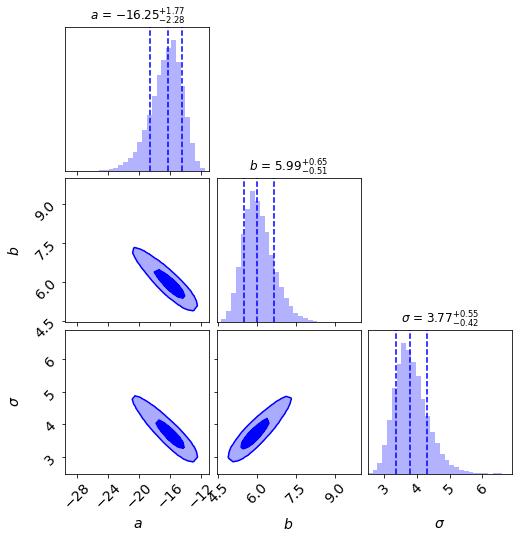

In [219]:
fig = corner(mcmc_samples.T, bins=30, smooth=1,
             # range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 12})

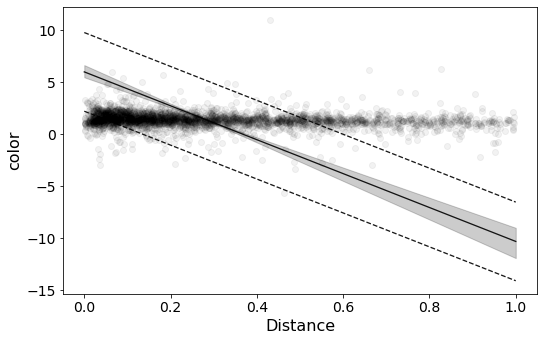

In [222]:
#plotting code based off of Hailey's notebook

from matplotlib.patches import Ellipse

nbins = 100
sigmas = hf.get_sigmas()
xvals = np.linspace(0, 1, nbins)
yvals = hf.coords[0] * xvals + hf.coords[1]
#yvals = hf.coords[1]

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = data #[log10vmax[isrmeas], rmag[isrmeas]]
x_err = np.full(3505, (1/nbins)) #np.ones(3505) #dlog10vmax[isrmeas]
#x_err = np.full(3080, (1/nbins)) #when masking values above 1 Mpc/h
y_err = du_r #drmag[isrmeas]
corr_xy = np.zeros_like(x_err)

# Generate ellipses
# ells = [
#     Ellipse(
#         #xy=[data[0][i], data[1][i]],
#         xy=[xvals[i], yvals[i]],
#         width=2.0 * y_err[i],
#         height=2.0 * x_err[i],
#         angle=np.rad2deg(np.arccos(corr_xy[i])),
#     )
#     #for i in range(len(data[0]))
#     for i in range(len(xvals))
# ]

# Make the plot
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])
# for i, e in enumerate(ells):
#     ax.add_artist(e)
#     #e.set_color(cmocean.cm.thermal(sigmas[i] / np.amax(sigmas)))
#     e.set_edgecolor('None')
#     e.set_alpha(0.9)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('color', fontsize=16)
#ax.set_title(r"Coma", fontsize = 16)
# ax.set_xlim(0, 3)
# ax.set_ylim(-0., 3)

ax.scatter(data[0], data[1], alpha=0.05, color='k', marker='o') #plotting the actual scatter

# Add the colourbar
#cb = fig.colorbar(
    #cm.ScalarMappable(norm=colors.Normalize(vmin=0.0, vmax=np.amax(sigmas)), cmap = cmocean.cm.thermal),
    #ax=ax,
    #shrink=0.5,
    #aspect=10,
    #anchor=(-8, 0.95),
#)
#b.set_label(label=r"$\sigma$", fontsize=14)

# Using Profile Histogram Function for HyperFit

### Testing with wall dwarf galaxies for color

In [444]:
neigh_dist2d = dwarf_table[dwarf_wall]['2D_neighbor_dist'].value
u_r  = dwarf_table[dwarf_wall]['u_r'].value
du_r = dwarf_table[dwarf_wall]['u_r_err'].value

# Cut out the NaNs from the dwarf table.
select = ~np.isnan(u_r) & ~np.isnan(du_r) & (neigh_dist2d <= 1.)

neigh_dist2d = neigh_dist2d[select]
u_r  = u_r[select]
du_r = du_r[select]


#### Option: Try Cleaning to Keep Points with Small Relative Uncertainties

Keep only points with relative uncertainties below 10%.

In [445]:
select = du_r / np.abs(u_r) < 0.1
neigh_dist2d_clean = neigh_dist2d[select]
u_r_clean = u_r[select]
du_r_clean = du_r[select]

## Key

#### c_ = cleaned data
#### w_ = weighted raw data
#### cw_ = cleaned weighted data

## Profile Histogram with Equal Weight Binning

Cleaned data

In [477]:
c_dist, c_u_r_avg, c_u_r_err = profilehist(neigh_dist2d_clean, u_r_clean, bins=30, uncertainty='stderr')
c_dist_err = 0.5*np.diff(dist)[0] #unsure if this error is actually the size of the bin

Raw data

In [447]:
dist, u_r_avg, u_r_err = profilehist(neigh_dist2d, u_r, bins=30, uncertainty='stderr')
dist_err = 0.5*np.diff(dist)[0]

In [404]:
len(u_r_err)

30

## Profile Histogram with Weighted Binning $w_i=1/\sigma_i^2$

In [448]:
cw_dist, cw_u_r_avg, cw_u_r_err = profilehist(neigh_dist2d_clean, u_r_clean, w=1./du_r_clean**2, bins=30, uncertainty='stderr')

cw_dist_err = 0.5*np.diff(dist)[0]

In [449]:
w_dist, w_u_r_avg, w_u_r_err = profilehist(neigh_dist2d, u_r, w=1./du_r**2, bins=30, uncertainty='stderr')

w_dist_err = 0.5*np.diff(dist)[0]

## Packing Data into format for Hyperfit

In [450]:
ndata = len(u_r_avg)
cov = np.empty((2, 2, ndata))
data = np.empty((2, ndata))

# Pack data into 2xN array and covariances into 2x2xN array.
for i, (_dist, _u_r, _du_r) in enumerate(zip(dist, u_r_avg, u_r_err)):        
    data[0,i] = _dist
    data[1,i] = _u_r
    cov[:,:,i] = np.array([[0., 0.], [0., _du_r**2]])   
    

In [451]:
c_ndata = len(c_u_r_avg)
c_cov = np.empty((2, 2, ndata))
c_data = np.empty((2, ndata))

# Pack data into 2xN array and covariances into 2x2xN array.
for i, (_dist, _u_r, _du_r) in enumerate(zip(c_dist, c_u_r_avg, c_u_r_err)):        
    c_data[0,i] = _dist
    c_data[1,i] = _u_r
    c_cov[:,:,i] = np.array([[0., 0.], [0., _du_r**2]])   
    

#### Weighted Values

In [452]:
w_ndata = len(w_u_r_avg)
w_cov = np.empty((2, 2, ndata))
w_data = np.empty((2, ndata))

# Pack data into 2xN array and covariances into 2x2xN array.
for i, (_dist, _u_r, _du_r) in enumerate(zip(w_dist, w_u_r_avg, w_u_r_err)):        
    w_data[0,i] = _dist
    w_data[1,i] = _u_r
    w_cov[:,:,i] = np.array([[0., 0.], [0., _du_r**2]])

In [453]:
cw_ndata = len(cw_u_r_avg)
cw_cov = np.empty((2, 2, ndata))
cw_data = np.empty((2, ndata))

# Pack data into 2xN array and covariances into 2x2xN array.
for i, (_dist, _u_r, _du_r) in enumerate(zip(cw_dist, cw_u_r_avg, cw_u_r_err)):        
    cw_data[0,i] = _dist
    cw_data[1,i] = _u_r
    cw_cov[:,:,i] = np.array([[0., 0.], [0., _du_r**2]])

### Fitting data to hyperfit

In [454]:
hf = LinFit(data, cov)
print(hf)

In [455]:
c_hf = LinFit(c_data, c_cov)
print(c_hf)

In [456]:
w_hf = LinFit(w_data, w_cov)
print(w_hf)

In [457]:
cw_hf = LinFit(cw_data, cw_cov)
print(cw_hf)

In [458]:
bounds = ((-10,10), (-10,10), (1e-5,5))
# bounds = ((-0.1,0.1), (-1,2), (1e-5,5))
result = hf.optimize(bounds, verbose=True)
result

     fun: array([-61.5466199])
     jac: array([ 0.00496883, -0.00368203,  0.00030838])
 message: 'Optimization terminated successfully.'
    nfev: 2094
     nit: 45
 success: True
       x: array([0.66656741, 1.16815243, 0.01618974])


(array([-0.57061681,  1.548507  ]), 0.019467270310092634, 61.54661989793907)

In [459]:
c_bounds = ((-10,10), (-10,10), (1e-5,5))
# bounds = ((-0.1,0.1), (-1,2), (1e-5,5))
c_result = c_hf.optimize(c_bounds, verbose=True)
c_result

     fun: array([-67.71929516])
     jac: array([-1.13686838e-05, -2.70006241e-05, -1.42108547e-06])
 message: 'Optimization terminated successfully.'
    nfev: 2466
     nit: 53
 success: True
       x: array([0.42090773, 1.42648569, 0.01951179])


(array([-0.29506621,  1.55068134]), 0.02124628627470538, 67.71929515815798)

In [460]:
w_bounds = ((-10,10), (-10,10), (1e-5,5))
# bounds = ((-0.1,0.1), (-1,2), (1e-5,5))
w_result = w_hf.optimize(w_bounds, verbose=True)
w_result

     fun: array([-39.1520194])
     jac: array([ 7.03437308e-05,  7.74491587e-05, -4.59721150e-04])
 message: 'Optimization terminated successfully.'
    nfev: 2118
     nit: 45
 success: True
       x: array([0.0142343 , 1.18488136, 0.16432676])


(array([-0.01201327,  1.18505237]), 0.17163191166635178, 39.15201940446168)

In [461]:
cw_bounds = ((-10,10), (-10,10), (1e-5,5))
# bounds = ((-0.1,0.1), (-1,2), (1e-5,5))
cw_result = cw_hf.optimize(cw_bounds, verbose=True)
cw_result

     fun: array([-35.09235807])
     jac: array([ 0.00172662, -0.00022311, -0.00151985])
 message: 'Optimization terminated successfully.'
    nfev: 1812
     nit: 39
 success: True
       x: array([-0.10323594,  1.15459691,  0.18816786])


(array([0.08941297, 1.16382754]), 0.19730267966552018, 35.092358069028556)

In [462]:
mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)
print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))

     fun: array([-61.54661982])
     jac: array([-0.00731006,  0.00509672,  0.00277041])
 message: 'Optimization terminated successfully.'
    nfev: 2139
     nit: 46
 success: True
       x: array([0.66653238, 1.16819024, 0.01619396])


100%|██████████| 1000/1000 [00:00<00:00, 1126.48it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [30.63969106 33.96526148 31.56899895] / 1698.263074243036


100%|██████████| 1000/1000 [00:00<00:00, 1110.38it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [36.73407698 40.86281653 34.9440017 ] / 2043.1408263685921


100%|██████████| 1000/1000 [00:00<00:00, 1111.15it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [38.54484928 39.91051725 34.6271885 ] / 1995.5258624798155
[-0.56168899  1.54695683  0.03161714] [0.05974264 0.02507052 0.01970022]


In [463]:
c_mcmc_samples, c_mcmc_lnlike = c_hf.emcee(c_bounds, verbose=True)
print(np.mean(c_mcmc_samples, axis=1), np.std(c_mcmc_samples, axis=1))

     fun: array([-67.71929516])
     jac: array([ 2.27373676e-05,  8.66862143e-05, -9.94759830e-06])
 message: 'Optimization terminated successfully.'
    nfev: 2421
     nit: 52
 success: True
       x: array([0.42090772, 1.42648571, 0.01951179])


100%|██████████| 1000/1000 [00:00<00:00, 1159.37it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.70177602 34.3060912  34.28326981] / 2285.08880082433


100%|██████████| 1000/1000 [00:00<00:00, 1116.79it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [32.48516809 30.24835742 31.46899136] / 1624.2584044824273


100%|██████████| 1000/1000 [00:00<00:00, 1123.56it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [36.09029335 34.58923795 30.65505251] / 1804.5146677488895


100%|██████████| 1000/1000 [00:00<00:00, 1164.24it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [33.31445268 35.27237019 42.88675332] / 2144.3376659374762


100%|██████████| 1000/1000 [00:00<00:00, 1183.32it/s]

Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [34.77090903 35.79151396 42.06115524] / 2103.057761877534
[-0.29045536  1.54933278  0.02718737] [0.04537721 0.02102861 0.01625317]


In [464]:
w_mcmc_samples, w_mcmc_lnlike = w_hf.emcee(w_bounds, verbose=True)
print(np.mean(w_mcmc_samples, axis=1), np.std(w_mcmc_samples, axis=1))

     fun: array([-39.15201932])
     jac: array([-0.00259845, -0.00025437,  0.00024158])
 message: 'Optimization terminated successfully.'
    nfev: 1681
     nit: 36
 success: True
       x: array([0.01417004, 1.18485565, 0.16432708])


100%|██████████| 1000/1000 [00:00<00:00, 1127.16it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.35464104 42.14453278 35.1266002 ] / 2167.7320518503448


100%|██████████| 1000/1000 [00:00<00:00, 1174.33it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.7893043  44.16098536 30.11671843] / 2289.4652147636416


100%|██████████| 1000/1000 [00:00<00:00, 1171.98it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [47.17156875 44.51111133 40.8979493 ] / 2358.5784375802655


100%|██████████| 1000/1000 [00:00<00:00, 1125.10it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [52.55432606 41.8582081  44.40661637] / 2627.7163031349955


100%|██████████| 1000/1000 [00:00<00:00, 1095.24it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.92660824 43.26278701 42.38852884] / 2296.330412030245


100%|██████████| 1000/1000 [00:00<00:00, 1082.49it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [54.10736727 53.03071218 42.53399123] / 2705.368363406764


100%|██████████| 1000/1000 [00:00<00:00, 1107.58it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [61.36843941 56.35091247 47.02332053] / 3068.4219704211137


100%|██████████| 1000/1000 [00:00<00:00, 1104.61it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [69.89931374 64.30675432 46.15598513] / 3494.965686785146


100%|██████████| 1000/1000 [00:00<00:00, 1109.08it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [73.11952308 62.97769744 47.97130542] / 3655.9761541992643
[-0.02435978  1.19233503  0.17983683] [0.14725582 0.07995782 0.02606447]


In [465]:
cw_mcmc_samples, cw_mcmc_lnlike = cw_hf.emcee(cw_bounds, verbose=True)
print(np.mean(cw_mcmc_samples, axis=1), np.std(cw_mcmc_samples, axis=1))

     fun: array([-35.09235787])
     jac: array([ 0.00275406,  0.0018531 , -0.00069349])
 message: 'Optimization terminated successfully.'
    nfev: 2176
     nit: 47
 success: True
       x: array([-0.10316522,  1.15464468,  0.18816834])


100%|██████████| 1000/1000 [00:00<00:00, 1166.75it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [46.08400317 53.85777161 41.91736521] / 2692.8885802984373


100%|██████████| 1000/1000 [00:00<00:00, 1138.63it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [56.35652017 52.55758555 49.36161553] / 2817.8260086219016


100%|██████████| 1000/1000 [00:00<00:00, 1170.95it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [46.64820805 49.5791858  43.25344981] / 2478.9592900543507


100%|██████████| 1000/1000 [00:00<00:00, 1169.52it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [64.99051168 65.59110706 40.76247593] / 3279.5553529465465


100%|██████████| 1000/1000 [00:00<00:00, 1130.72it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [66.45435937 64.06822458 40.74037092] / 3322.7179685691835
[0.07392993 1.17213832 0.20903184] [0.18303193 0.10059292 0.03198991]


## Plotting Hyperfit

In [389]:
# a = slope, b = intercept, sig = error on intercept

a, b, sig    = np.mean(mcmc_samples, axis=1)
da, db, dsig = np.std(mcmc_samples, axis=1)
labels = ['a', 'b', 'sigma']

for label, val, err in zip(labels, (a, b, sig), (da, db, dsig)):
    print('{:6s}= {:6.3f} +/- {:.3f}'.format(label, val, err))

a     = -0.292 +/- 0.046
b     =  1.550 +/- 0.021
sigma =  0.028 +/- 0.016


#### test to see if the slopes above change

In [466]:
# a = slope, b = intercept, sig = error on intercept

a, b, sig    = np.mean(mcmc_samples, axis=1)
da, db, dsig = np.std(mcmc_samples, axis=1)
labels = ['a', 'b', 'sigma']

for label, val, err in zip(labels, (a, b, sig), (da, db, dsig)):
    print('{:6s}= {:6.3f} +/- {:.3f}'.format(label, val, err))

a     = -0.562 +/- 0.060
b     =  1.547 +/- 0.025
sigma =  0.032 +/- 0.020


In [467]:
# a = slope, b = intercept, sig = error on intercept

c_a, c_b, c_sig    = np.mean(c_mcmc_samples, axis=1)
c_da, c_db, c_dsig = np.std(c_mcmc_samples, axis=1)
c_labels = ['c_a', 'c_b', 'c_sigma']

for c_label, c_val, c_err in zip(c_labels, (c_a, c_b, c_sig), (c_da, c_db, c_dsig)):
    print('{:6s}= {:6.3f} +/- {:.3f}'.format(c_label, c_val, c_err))

c_a   = -0.290 +/- 0.045
c_b   =  1.549 +/- 0.021
c_sigma=  0.027 +/- 0.016


In [468]:
# w_a = slope, w_b = intercept, w_sig = error on intercept

w_a, w_b, w_sig    = np.mean(w_mcmc_samples, axis=1)
w_da, w_db, w_dsig = np.std(w_mcmc_samples, axis=1)
w_labels = ['w_a', 'w_b', 'w_sigma']

for w_label, w_val, w_err in zip(w_labels, (w_a, w_b, w_sig), (w_da, w_db, w_dsig)):
    print('{:6s}= {:6.3f} +/- {:.3f}'.format(w_label, w_val, w_err))

w_a   = -0.024 +/- 0.147
w_b   =  1.192 +/- 0.080
w_sigma=  0.180 +/- 0.026


In [469]:
# w_a = slope, w_b = intercept, w_sig = error on intercept

cw_a, cw_b, cw_sig    = np.mean(cw_mcmc_samples, axis=1)
cw_da, cw_db, cw_dsig = np.std(cw_mcmc_samples, axis=1)
cw_labels = ['cw_a', 'cw_b', 'cw_sigma']

for cw_label, cw_val, cw_err in zip(cw_labels, (cw_a, cw_b, cw_sig), (cw_da, cw_db, cw_dsig)):
    print('{:6s}= {:6.3f} +/- {:.3f}'.format(cw_label, cw_val, cw_err))

cw_a  =  0.074 +/- 0.183
cw_b  =  1.172 +/- 0.101
cw_sigma=  0.209 +/- 0.032


#### Corner Plot

In [319]:
from corner import corner

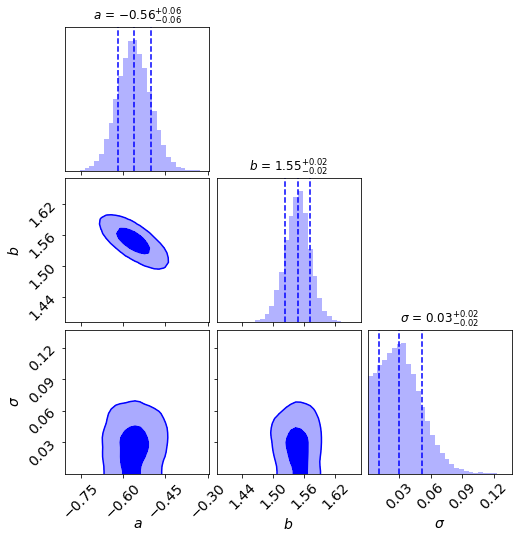

In [470]:
fig = corner(mcmc_samples.T, bins=30, smooth=1,
             # range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 12})

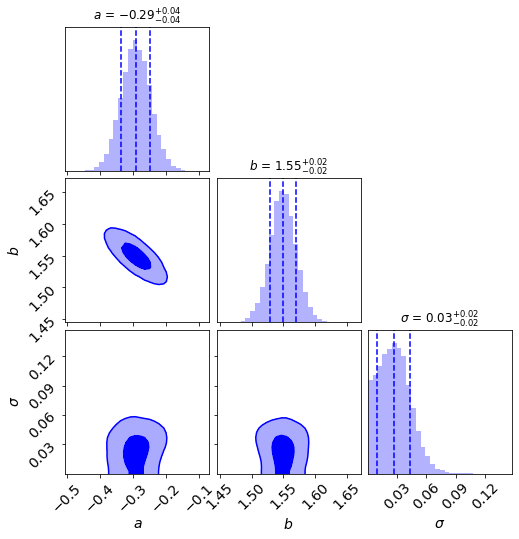

In [471]:
fig = corner(c_mcmc_samples.T, bins=30, smooth=1,
             # range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 12})

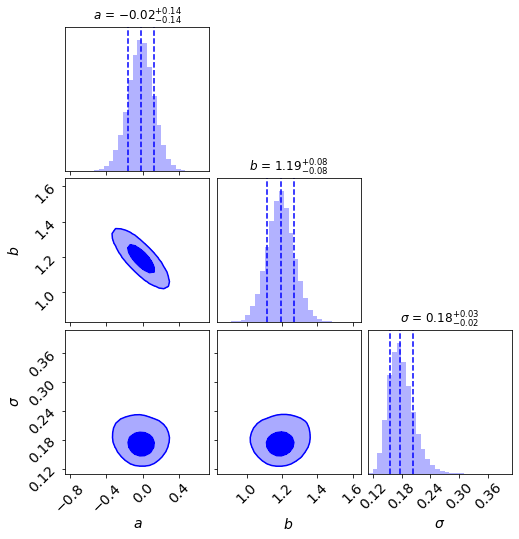

In [472]:
fig = corner(w_mcmc_samples.T, bins=30, smooth=1,
             # range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 12})

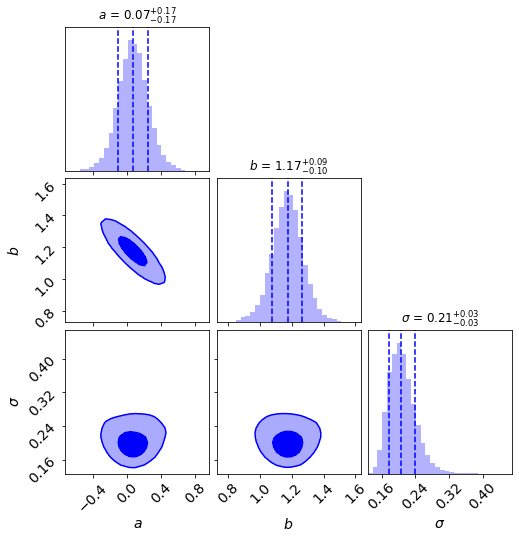

In [473]:
fig = corner(cw_mcmc_samples.T, bins=30, smooth=1,
             # range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 12})

### Making Plot

Text(0.5, 1.0, 'Equal-Weight Bins')

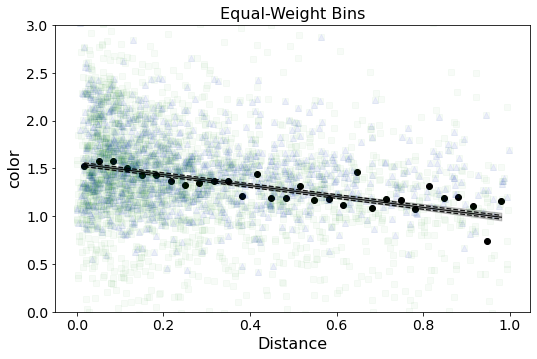

In [474]:
#plotting code based off of Hailey's notebook

from matplotlib.patches import Ellipse

#nbins = len(dist)

sigmas = hf.get_sigmas()

#xvals = np.linspace(0, 1, nbins)
xvals = dist

yvals = hf.coords[0] * xvals + hf.coords[1]
#yvals = hf.coords[1]


# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)


# Pack info into data
data = data #[log10vmax[isrmeas], rmag[isrmeas]]

#x_err = np.full(3505, (1/nbins)) #np.ones(3505) #dlog10vmax[isrmeas]
#x_err = np.full(3080, (1/nbins)) #when masking values above 1 Mpc/h
x_err = dist_err

#y_err = du_r #drmag[isrmeas]
y_err = u_r_err
corr_xy = np.zeros_like(x_err)

# Generate ellipses
# ells = [
#     Ellipse(
#         #xy=[data[0][i], data[1][i]],
#         xy=[xvals[i], yvals[i]],
#         width=2.0 * y_err[i],
#         height=2.0 * x_err[i],
#         angle=np.rad2deg(np.arccos(corr_xy[i])),
#     )
#     #for i in range(len(data[0]))
#     for i in range(len(xvals))
# ]    
       
    
# Make the plot
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])
# for i, e in enumerate(ells):
#     ax.add_artist(e)
#     #e.set_color(cmocean.cm.thermal(sigmas[i] / np.amax(sigmas)))
#     e.set_edgecolor('None')
#     e.set_alpha(0.9)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('color', fontsize=16)
#ax.set_title(r"Coma", fontsize = 16)
# ax.set_xlim(0, 3)
# ax.set_ylim(-0., 3)

ax.scatter(data[0], data[1], alpha=1, color='k', marker='o') #plotting profile Hist binned points

ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'b', marker = '^') #plotting full cleaned data

ax.scatter(neigh_dist2d, u_r, alpha = 0.03, color = 'g', marker = 's') #plotting full data

ax.set_ylim(0., 3)
#ax.set_ylim(1, 1.8)

ax.set_title('Equal-Weight Bins', fontsize = 16)

Text(0.5, 1.0, 'Cleaned, Equal-Weight Bins')

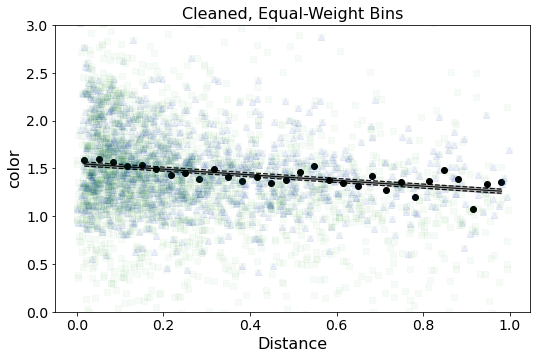

In [418]:
#plotting code based off of Hailey's notebook

from matplotlib.patches import Ellipse

#nbins = len(dist)

sigmas = hf.get_sigmas()

#xvals = np.linspace(0, 1, nbins)
xvals = dist

yvals = hf.coords[0] * xvals + hf.coords[1]
#yvals = hf.coords[1]


# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)


# Pack info into data
data = data #[log10vmax[isrmeas], rmag[isrmeas]]

#x_err = np.full(3505, (1/nbins)) #np.ones(3505) #dlog10vmax[isrmeas]
#x_err = np.full(3080, (1/nbins)) #when masking values above 1 Mpc/h
x_err = dist_err

#y_err = du_r #drmag[isrmeas]
y_err = u_r_err
corr_xy = np.zeros_like(x_err)

# Generate ellipses
# ells = [
#     Ellipse(
#         #xy=[data[0][i], data[1][i]],
#         xy=[xvals[i], yvals[i]],
#         width=2.0 * y_err[i],
#         height=2.0 * x_err[i],
#         angle=np.rad2deg(np.arccos(corr_xy[i])),
#     )
#     #for i in range(len(data[0]))
#     for i in range(len(xvals))
# ]    
       
    
# Make the plot
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])
# for i, e in enumerate(ells):
#     ax.add_artist(e)
#     #e.set_color(cmocean.cm.thermal(sigmas[i] / np.amax(sigmas)))
#     e.set_edgecolor('None')
#     e.set_alpha(0.9)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('color', fontsize=16)
#ax.set_title(r"Coma", fontsize = 16)
# ax.set_xlim(0, 3)
# ax.set_ylim(-0., 3)

ax.scatter(data[0], data[1], alpha=1, color='k', marker='o') #plotting profile Hist binned points

ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'b', marker = '^') #plotting full cleaned data

ax.scatter(neigh_dist2d, u_r, alpha = 0.03, color = 'g', marker = 's') #plotting full data

ax.set_ylim(0., 3)
#ax.set_ylim(1, 1.8)

ax.set_title('Equal-Weight Bins', fontsize = 16)

## Ploting profile Hist Hyperfit plots side by side

Text(0.5, 1.0, 'Weighted Bins ($w_i=1/\\sigma_i^2$)')

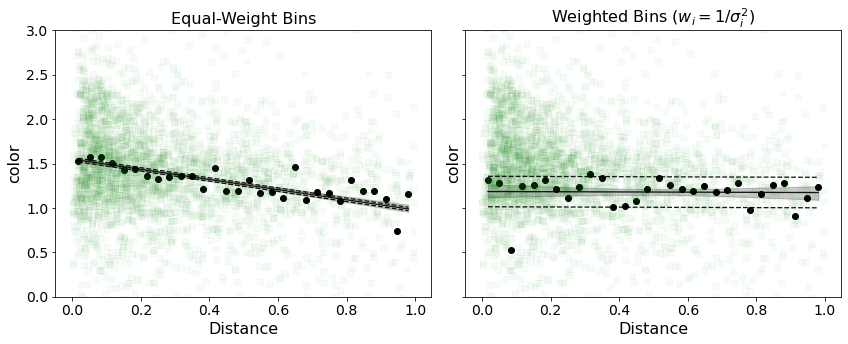

In [475]:
from matplotlib.patches import Ellipse

fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]

sigmas = hf.get_sigmas()
xvals = dist
yvals = hf.coords[0] * xvals + hf.coords[1]


# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)


# Pack info into data
data = data 
x_err = dist_err
y_err = u_r_err
corr_xy = np.zeros_like(x_err)

# Make the plot
#fig = plt.figure(figsize=(6.4,4.8))
#ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])

ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('color', fontsize=16)


ax.scatter(data[0], data[1], alpha=1, color='k', marker='o') #plotting profile Hist binned points

#ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'b', marker = '^') #plotting full cleaned data

ax.scatter(neigh_dist2d, u_r, alpha = 0.03, color = 'g', marker = 's') #plotting full data

#ax.set_ylim(0., 3)
ax.set_ylim(1, 1.8)

ax.set_title('Equal-Weight Bins', fontsize = 16)


ax = axes[1]

w_sigmas = w_hf.get_sigmas()
w_xvals = w_dist
w_yvals = w_hf.coords[0] * w_xvals + w_hf.coords[1]


# Get the MCMC 1-sigma quantiles to plot with the fit.
w_y_chain = np.outer(w_xvals, w_mcmc_samples[0]) + w_mcmc_samples[1]
w_y_chain_quantiles = np.quantile(w_y_chain, [0.1587, 0.8414], axis=1)


# Pack info into data
w_data = w_data 
w_x_err = w_dist_err
w_y_err = w_u_r_err
w_corr_xy = np.zeros_like(w_x_err)

# Make the plot
#fig = plt.figure(figsize=(6.4,4.8))
#ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])

ax.fill_between(w_xvals, w_y_chain_quantiles[0], w_y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(w_xvals, w_yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(w_xvals, w_yvals - w_hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(w_xvals, w_yvals + w_hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('color', fontsize=16)


ax.scatter(w_data[0], w_data[1], alpha=1, color='k', marker='o') #plotting profile Hist binned points

#ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'b', marker = '^') #plotting full cleaned data

ax.scatter(neigh_dist2d, u_r, alpha = 0.03, color = 'g', marker = 's') #plotting full data

ax.set_ylim(0., 3)
#ax.set_ylim(0.5, 1.8)

ax.set_title('Weighted Bins ($w_i=1/\sigma_i^2$)', fontsize = 16)

Text(0.5, 1.0, 'Cleaned, Weighted Bins ($w_i=1/\\sigma_i^2$)')

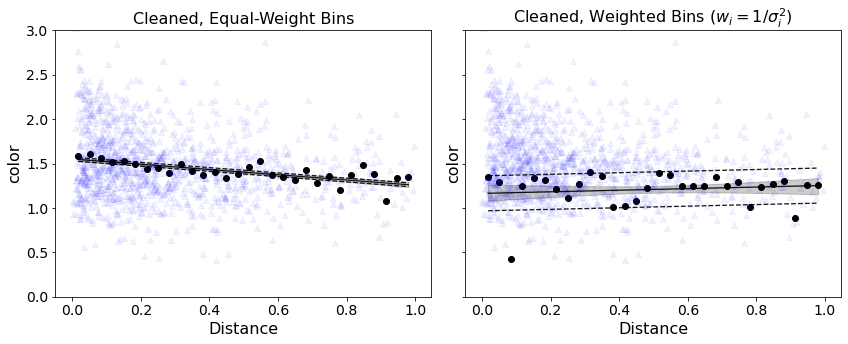

In [478]:
from matplotlib.patches import Ellipse

fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]

c_sigmas = c_hf.get_sigmas()
c_xvals = c_dist
c_yvals = c_hf.coords[0] * c_xvals + c_hf.coords[1]


# Get the MCMC 1-sigma quantiles to plot with the fit.
c_y_chain = np.outer(c_xvals, c_mcmc_samples[0]) + c_mcmc_samples[1]
c_y_chain_quantiles = np.quantile(c_y_chain, [0.1587, 0.8414], axis=1)


# Pack info into data
c_data = c_data 
c_x_err = c_dist_err
c_y_err = c_u_r_err
c_corr_xy = np.zeros_like(c_x_err)

# Make the plot
#fig = plt.figure(figsize=(6.4,4.8))
#ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])

ax.fill_between(c_xvals, c_y_chain_quantiles[0], c_y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(c_xvals, c_yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(c_xvals, c_yvals - c_hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(c_xvals, c_yvals + c_hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('color', fontsize=16)


ax.scatter(c_data[0], c_data[1], alpha=1, color='k', marker='o') #plotting profile Hist binned points

ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'b', marker = '^') #plotting full cleaned data

#ax.scatter(neigh_dist2d, u_r, alpha = 0.03, color = 'g', marker = 's') #plotting full data

#ax.set_ylim(0., 3)
ax.set_ylim(1, 1.8)

ax.set_title('Cleaned, Equal-Weight Bins', fontsize = 16)


ax = axes[1]

cw_sigmas = cw_hf.get_sigmas()
cw_xvals = cw_dist
cw_yvals = cw_hf.coords[0] * cw_xvals + cw_hf.coords[1]


# Get the MCMC 1-sigma quantiles to plot with the fit.
cw_y_chain = np.outer(cw_xvals, cw_mcmc_samples[0]) + cw_mcmc_samples[1]
cw_y_chain_quantiles = np.quantile(cw_y_chain, [0.1587, 0.8414], axis=1)


# Pack info into data
cw_data = cw_data 
cw_x_err = cw_dist_err
cw_y_err = cw_u_r_err
cw_corr_xy = np.zeros_like(cw_x_err)

# Make the plot
#fig = plt.figure(figsize=(6.4,4.8))
#ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])

ax.fill_between(cw_xvals, cw_y_chain_quantiles[0], cw_y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(cw_xvals, cw_yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(cw_xvals, cw_yvals - cw_hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(cw_xvals, cw_yvals + cw_hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('color', fontsize=16)


ax.scatter(cw_data[0], cw_data[1], alpha=1, color='k', marker='o') #plotting profile Hist binned points

ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'b', marker = '^') #plotting full cleaned data

#ax.scatter(neigh_dist2d, u_r, alpha = 0.03, color = 'g', marker = 's') #plotting full data

ax.set_ylim(0., 3)
#ax.set_ylim(0.5, 1.8)

ax.set_title('Cleaned, Weighted Bins ($w_i=1/\sigma_i^2$)', fontsize = 16)

# Looking into linregress

slopes: -0.3133553028233604 -0.2737574674675049 -0.007896960624011861


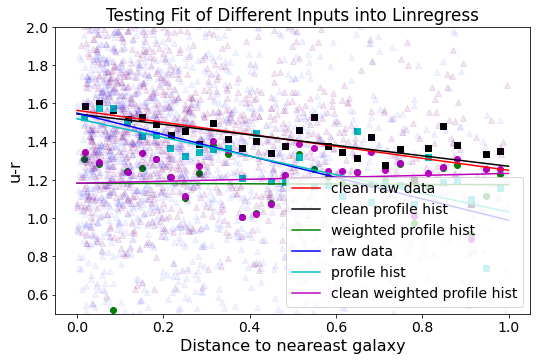

In [560]:
result1 = stats.linregress(neigh_dist2d_clean, u_r_clean)
result2 = stats.linregress(c_data[0], c_data[1]) 
result3 = stats.linregress(w_data[0], w_data[1])
result4 = stats.linregress(neigh_dist2d, u_r)
result5 = stats.linregress(data[0], data[1])
result6 = stats.linregress(cw_data[0], cw_data[1])
#fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True, tight_layout=True)

#ax = axes[0]

fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])

x = np.linspace(0,1,31)
#x_raw = neigh_dist2d_clean
y = result1.slope*x+result1.intercept
#y_raw = result1.slope*x_raw+result1.intercept
ax.plot(x, y, '-r', label = 'clean raw data') #, label='y=2x+1')
#ax.plot(x_raw, y_raw, '-b', label = 'clean raw raw data') 
y2 = result2.slope*x+result2.intercept
ax.plot(x, y2, '-k', label = 'clean profile hist')
y3 = result3.slope*x+result3.intercept
ax.plot(x, y3, '-g', label = 'weighted profile hist') 
y4 = result4.slope*x+result4.intercept
ax.plot(x, y4, '-b', label = 'raw data')
y5 = result5.slope*x+result5.intercept
ax.plot(x, y5, '-c', label = 'profile hist')
y6 = result6.slope*x+result6.intercept
ax.plot(x, y6, '-m', label = 'clean weighted profile hist')
 
ax.scatter(w_data[0], w_data[1], alpha=1, color='g', marker='o') #plotting profile Hist binned points
ax.scatter(cw_data[0], cw_data[1], alpha=1, color='m', marker='o') #plotting profile Hist binned points
ax.scatter(c_data[0], c_data[1], alpha=1, color='k', marker='s') #plotting profile Hist binned points
ax.scatter(data[0], data[1], alpha=1, color='c', marker='s') #plotting profile Hist binned points
ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'r', marker = '^') #plotting full cleaned data    
ax.scatter(neigh_dist2d, u_r, alpha = 0.05, color = 'b', marker = '^')
#ax = axes[1]
ax.set_ylim(0.5, 2)
ax.set_xlabel('Distance to neareast galaxy', fontsize=16)
ax.set_ylabel('u-r', fontsize=16)
ax.set_title('Testing Fit of Different Inputs into Linregress')
ax.legend()
print('slopes:', result1.slope, result2.slope, result3.slope)

# Finding best method to get most accurate fit
### Using Simulated data with a known linear relationship to see which fit matches the best

In [552]:
dy = np.random.random_sample(len(y))

"\n#histograms\n\nax = axes[1,0]\nax.hist(x)\nax.set(xlabel='$x$', ylabel='count', title='Histogram of $x$ values')\n\nax = axes[1,1]\nax.hist(y)\nax.set(xlabel='$y$', ylabel='count', title='Histogram of $y$ values')\n"

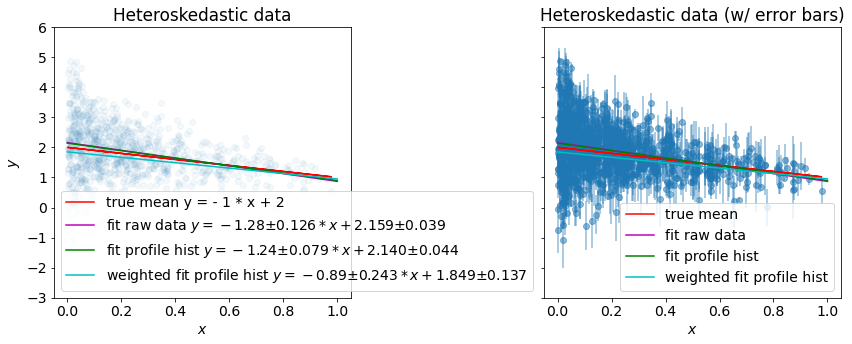

In [553]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.RandomState(42)
x = rng.exponential(scale=0.25, size=1000)
x = x[x <= 1]
y_true_mean = 2 - 1 * x
y = y_true_mean + rng.normal(loc=0, scale=0.2 + 0.2*(x+0.1)**-0.75, size=x.shape[0])
#dy = np.ones_like(y)
#dy = np.random.random_sample(len(y))
dy = dy

# adding profile hist function on simulated data
hist_x, hist_y, hist_y_err = profilehist(x, y, bins=30, uncertainty='stderr')
hist_x_err = 0.5*np.diff(x)[0]

w_hist_x, w_hist_y, w_hist_y_err = profilehist(x, y, w=1./dy**2, bins=30, uncertainty='stderr')
w_hist_x_err = 0.5*np.diff(x)[0]


#adding linregress checks
result1 = stats.linregress(x, y)
result2 = stats.linregress(hist_x, hist_y)
result3 = stats.linregress(w_hist_x, w_hist_y)


#Plotting Results

#fig, axes = plt.subplots(2,2, figsize=(10,8), tight_layout=True)
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True, tight_layout=True)

#ax = axes[0,0]
ax = axes[0]

#ax.scatter(x,y, alpha=0.05, label='heteroskedastic data', zorder=1)
ax.scatter(x,y, alpha=0.05, zorder=1)
ax.plot(x,y_true_mean, '-r', label='true mean y = - 1 * x + 2', zorder=2)
ax.set(title='Heteroskedastic data', ylim=(-3,6), ylabel='$y$', xlabel='$x$')

#plotting linregress outputs
fit_x = np.linspace(0,1,30)
y1 = result1.slope*fit_x+result1.intercept
ax.plot(fit_x, y1, '-m', label = 'fit raw data $y=%3.5s ± %3.5s*x+%3.5s ± %3.5s$'%(result1.slope, 
                                                                                   result1.stderr,
                                                                                   result1.intercept,
                                                                                   result1.intercept_stderr))



y2 = result2.slope*fit_x+result2.intercept
ax.plot(fit_x, y2, '-g', label = 'fit profile hist $y=%3.5s ± %3.5s*x+%3.5s ± %3.5s$'%(result2.slope, 
                                                                                   result2.stderr,
                                                                                   result2.intercept,
                                                                                   result2.intercept_stderr))

y3 = result3.slope*fit_x+result3.intercept
ax.plot(fit_x, y3, '-c', label = 'weighted fit profile hist $y=%3.5s ± %3.5s*x+%3.5s ± %3.5s$'%(result3.slope, 
                                                                                   result3.stderr,
                                                                                   result3.intercept,
                                                                                   result3.intercept_stderr))
ax.set_ylim(0, 3)
ax.legend();


#ax = axes[0,1]
ax = axes[1]

#ax.errorbar(x,y, yerr=dy, fmt='o', alpha=0.05, label='heteroskedastic data', zorder=1)
ax.errorbar(x,y, yerr=dy, fmt='o', alpha=0.5, zorder=1)
ax.plot(x,y_true_mean, '-r', label='true mean', zorder=2)
ax.set(title='Heteroskedastic data (w/ error bars)', ylim=(-3,6), xlabel='$x$')

#plotting linregress outputs
fit_x = np.linspace(0,1,30)
y1 = result1.slope*fit_x+result1.intercept
ax.plot(fit_x, y1, '-m', label = 'fit raw data')

y2 = result2.slope*fit_x+result2.intercept
ax.plot(fit_x, y2, '-g', label = 'fit profile hist')

y3 = result3.slope*fit_x+result3.intercept
ax.plot(fit_x, y3, '-c', label = 'weighted fit profile hist')

#ax.set_ylim(0, 3)
ax.legend();
        
'''
#histograms

ax = axes[1,0]
ax.hist(x)
ax.set(xlabel='$x$', ylabel='count', title='Histogram of $x$ values')

ax = axes[1,1]
ax.hist(y)
ax.set(xlabel='$y$', ylabel='count', title='Histogram of $y$ values')
'''

[Text(0.5, 0, '$y$'),
 Text(0, 0.5, 'count'),
 Text(0.5, 1.0, 'Histogram of $y$ values')]

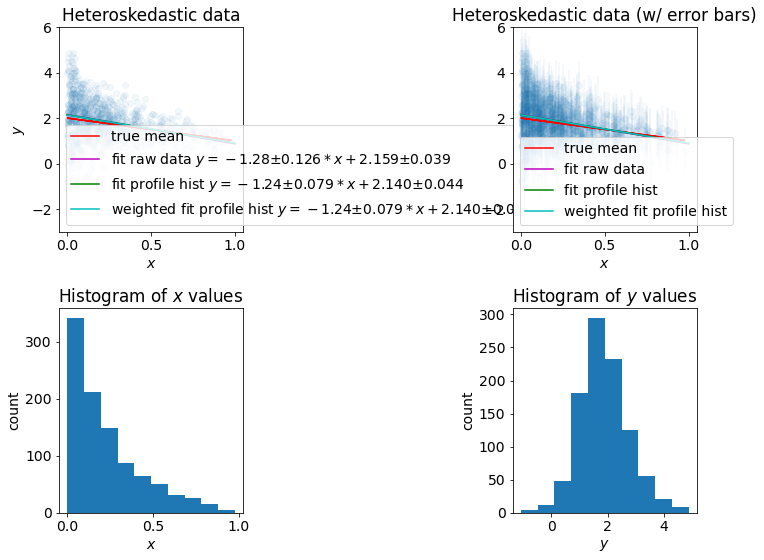

In [534]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.RandomState(42)
x = rng.exponential(scale=0.25, size=1000)
x = x[x <= 1]
y_true_mean = 2 - 1 * x
y = y_true_mean + rng.normal(loc=0, scale=0.2 + 0.2*(x+0.1)**-0.75, size=x.shape[0])
dy = np.ones_like(y)
#dy = np.random.random_sample(len(y))
#dy = dy

# adding profile hist function on simulated data
hist_x, hist_y, hist_y_err = profilehist(x, y, bins=30, uncertainty='stderr')
hist_x_err = 0.5*np.diff(x)[0]

w_hist_x, w_hist_y, w_hist_y_err = profilehist(x, y, w=1./dy**2, bins=30, uncertainty='stderr')
w_hist_x_err = 0.5*np.diff(x)[0]


#adding linregress checks
result1 = stats.linregress(x, y)
result2 = stats.linregress(hist_x, hist_y)
result3 = stats.linregress(w_hist_x, w_hist_y)


#Plotting Results

fig, axes = plt.subplots(2,2, figsize=(10,8), tight_layout=True)
#fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True, tight_layout=True)

ax = axes[0,0]
#ax = axes[0]

#ax.scatter(x,y, alpha=0.05, label='heteroskedastic data', zorder=1)
ax.scatter(x,y, alpha=0.05, zorder=1)
ax.plot(x,y_true_mean, '-r', label='true mean', zorder=2)
ax.set(title='Heteroskedastic data', ylim=(-3,6), ylabel='$y$', xlabel='$x$')

#plotting linregress outputs
fit_x = np.linspace(0,1,30)
y1 = result1.slope*fit_x+result1.intercept
ax.plot(fit_x, y1, '-m', label = 'fit raw data $y=%3.5s ± %3.5s*x+%3.5s ± %3.5s$'%(result1.slope, 
                                                                                   result1.stderr,
                                                                                   result1.intercept,
                                                                                   result1.intercept_stderr))



y2 = result2.slope*fit_x+result2.intercept
ax.plot(fit_x, y2, '-g', label = 'fit profile hist $y=%3.5s ± %3.5s*x+%3.5s ± %3.5s$'%(result2.slope, 
                                                                                   result2.stderr,
                                                                                   result2.intercept,
                                                                                   result2.intercept_stderr))

y3 = result3.slope*fit_x+result3.intercept
ax.plot(fit_x, y3, '-c', label = 'weighted fit profile hist $y=%3.5s ± %3.5s*x+%3.5s ± %3.5s$'%(result3.slope, 
                                                                                   result3.stderr,
                                                                                   result3.intercept,
                                                                                   result3.intercept_stderr))
#ax.set_ylim(0, 3)
ax.legend();


ax = axes[0,1]
#ax = axes[1]

#ax.errorbar(x,y, yerr=dy, fmt='o', alpha=0.05, label='heteroskedastic data', zorder=1)
ax.errorbar(x,y, yerr=dy, fmt='o', alpha=0.05, zorder=1)
ax.plot(x,y_true_mean, '-r', label='true mean', zorder=2)
ax.set(title='Heteroskedastic data (w/ error bars)', ylim=(-3,6), xlabel='$x$')

#plotting linregress outputs
fit_x = np.linspace(0,1,30)
y1 = result1.slope*fit_x+result1.intercept
ax.plot(fit_x, y1, '-m', label = 'fit raw data')

y2 = result2.slope*fit_x+result2.intercept
ax.plot(fit_x, y2, '-g', label = 'fit profile hist')

y3 = result3.slope*fit_x+result3.intercept
ax.plot(fit_x, y3, '-c', label = 'weighted fit profile hist')

#ax.set_ylim(0, 3)
ax.legend();
        

#histograms

ax = axes[1,0]
ax.hist(x)
ax.set(xlabel='$x$', ylabel='count', title='Histogram of $x$ values')

ax = axes[1,1]
ax.hist(y)
ax.set(xlabel='$y$', ylabel='count', title='Histogram of $y$ values')


## looking at linregress in my 2D color plot for linear regressions

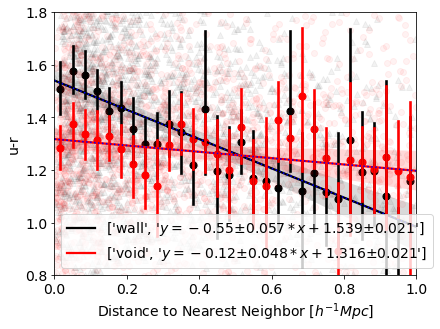

In [438]:
from scipy import stats
d_max = 1
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    #d_all = dwarf_table['2D_neighbor_dist'][select & sfd]
    #vals_all = dwarf_table['u_r'][select & sfd]
    
    d_all = dwarf_table['2D_neighbor_dist'][select]
    vals_all = dwarf_table['u_r'][select]

    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
    
    #slope, intercept, r_value, pv, stderr, intercept_stderr = stats.linregress(d[nonan], vals[nonan])
    
    result = stats.linregress(d[nonan], vals[nonan])
    
    
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax,  
                line_kws={'label': [label, '$y=%3.5s ± %3.5s*x+%3.5s ± %3.5s$'%(result.slope, 
                                                                                result.stderr, 
                                                                                result.intercept, 
                                                                                result.intercept_stderr)]})
    #test for linregress:
    x = xedges
    y = result.slope*x+result.intercept
    ax.plot(x, y, ':b') 
   
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='u-r', xlim=(0,1), ylim=(0.8,1.8));
        
    ax.legend(prop={'size': 14})

'''
# Z test and P Value Calculation    
    
    if c == 'k': #condition that determines whether or not you're looking at the void or wall sample
        wall_slope = result.slope
        wall_slope_err = result.stderr
        wall_intercept = result.intercept
        wall_intercept_err = result.intercept_stderr
        
    else: # 
        void_slope = result.slope
        void_slope_err = result.stderr
        void_intercept = result.intercept
        void_intercept_err = result.intercept_stderr
    
ur_slope = zscore_pvalue(wall_slope, void_slope, wall_slope_err, void_slope_err)    
ur_intercept = zscore_pvalue(wall_intercept, void_intercept, wall_intercept_err, void_intercept_err) 

print(ur_slope)
print(ur_intercept)
''';

# Code Unrelated to Hyperfit

ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

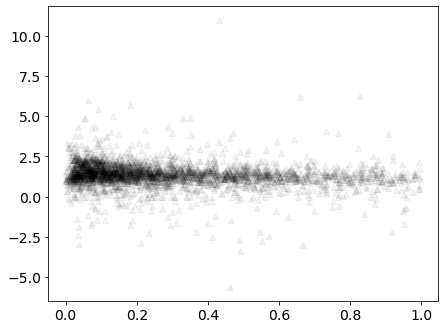

In [15]:
from scipy import stats
d_max = 1
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})

bounds = ((-1,1), (1,2), (1e-5,5))

for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    #d_all = dwarf_table['2D_neighbor_dist'][select & sfd]
    #vals_all = dwarf_table['u_r'][select & sfd]
    
    d_all = dwarf_table['2D_neighbor_dist'][select]
    vals_all = dwarf_table['u_r'][select]

    vals_all_err = dwarf_table['u_r_err'][select]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    vals_err = vals_all_err[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
    
    #slope, intercept, r_value, pv, stderr, intercept_stderr = stats.linregress(d[nonan], vals[nonan])
    
    #result = stats.linregress(d[nonan], vals[nonan])
    
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label,
                #line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax,  
                #line_kws={'label': [label, '$y=%3.7s*x+%3.7s$'%(slope, intercept)]})
    
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax,  
                #line_kws={'label': [label, '$y=%3.7s*x+%3.7s$'%(result.slope, result.intercept)]})
    
    
    #xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=bins, uncertainty='sample') #if want fit on binned data
    
    
    ndata = 100 #number of bins
    x_true = d[nonan]#np.random.rand(ndata)
    y_true = vals[nonan]#np.random.normal(2.0 * x_true + 1.0, 0.2)

    # Some correlated measurements of the x and y values with different errors and correlation coefficients
    x_err, y_err, corr_xy = 0, vals_err[nonan], 
    
    #(
        #0.05 * np.random.rand(ndata) + 0.025,
        #0.05 * np.random.rand(ndata) + 0.025,
        #2.0 * (np.random.rand(ndata) - 0.5),
    #)
    
    data, cov = np.empty((2, ndata)), np.empty((2, 2, ndata))
    for i, (x, y, ex, ey, rho_xy) in enumerate(zip(x_true, y_true, x_err, y_err, corr_xy)): #make corr_xy zeros
        cov[:, :, i] = np.array([[ex ** 2, ex * ey * rho_xy], [ex * ey * rho_xy, ey ** 2]])
        data[:, i] =  ([x, y], cov[:, :, i]) #np.random.multivariate_normal([x, y], cov[:, :, i])
    
    
    hf = LinFit(data, cov)    
   
    mcmc_samples, mcmc_lnlike = hf.emcee(bounds) 
    
    slope, intercept, scatter = np.mean(mcmc_samples, axis = 1)
    
    stderr, intercept_stderr, err_scatter = np.std(mcmc_samples, axis = 1)
    
    # now make the lines 

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='u-r', xlim=(0,1), ylim=(-0.5,3));
        
    ax.legend(prop={'size': 16})
    
    #print(result.stderr)
    #print(result.intercept_stderr)
        

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 1
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
 
    #d_all = dwarf_table['2D_neighbor_dist'][select & sfd]
    #vals_all = dwarf_table['u_r'][select & sfd]
    
    d_all = dwarf_table['2D_neighbor_dist'][select]
    vals_all = dwarf_table['u_r'][select]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    
    logbins = np.logspace(np.log10(0.01),np.log10(1),31) #making bins even logarithmicly  
    xcenters = 0.5*(logbins[1:] + logbins[:-1])
        
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
          
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='u-r', xlim=(0.01,1), ylim=(-0.5,3));
    
    ax.set_xscale('log')
    
    ax.legend()
    
    #fig.savefig('sfd_ur_2D_LR_log.png')
    #fig.savefig('ur_2D_LR_log.png')

## Star Formation Rate (sSFR)

### Profile Histogram

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_table['2D_neighbor_dist'][select & sfd]
    vals = dwarf_table['sSFR'][select & sfd]
    
    #d = dwarf_table['2D_neighbor_dist'][select]
    #vals = dwarf_table['sSFR'][select]
    
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.linspace(0,1,31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 1], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='sSFR [$yr^{-1}]$', xlim=([0,1]), ylim=(-11.5,-8.5));
    ax.legend();
    

    #fig.savefig('sfd_sSFR_2D_PH.png')
    #fig.savefig('sSFR_2D_PH.png')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    #d = dwarf_table['2D_neighbor_dist'][select & sfd]
    #vals = dwarf_table['sSFR'][select & sfd]
    
    d = dwarf_table['2D_neighbor_dist'][select]
    vals = dwarf_table['sSFR'][select]
    
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.logspace(np.log10(0.01),np.log10(1),31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 1], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='sSFR [$yr^{-1}]$', xlim=([0.01,1]), ylim=(-11.5,-8.5));
    ax.set_xscale('log') #changing x axis to a logarithmic scale

    ax.legend();

    #fig.savefig('sfd_sSFR_2D_PH_log.png')
    fig.savefig('sSFR_2D_PH_log.png')

### Linear Regression

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 1
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    #d_all = dwarf_table['2D_neighbor_dist'][select & sfd]
    #vals_all = dwarf_table['sSFR'][select & sfd]
    
    d_all = dwarf_table['2D_neighbor_dist'][select]
    vals_all = dwarf_table['sSFR'][select]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
    #slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                #line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})    
    
    result = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax,  
                line_kws={'label': [label, '$y=%3.7s*x+%3.7s$'%(result.slope, result.intercept)]})
    
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='sSFR [$yr^{-1}]$', xlim=(0,1), ylim=(-11.5,-8.5));
        
    ax.legend(prop={'size': 16})
    
    #slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    
    #print(slope)
    
        
    #fig.savefig('sfd_sSFR_2D_LR.png')
    #fig.savefig('sSFR_2D_LR.png')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 1
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d_all = dwarf_table['2D_neighbor_dist'][select & sfd]
    vals_all = dwarf_table['sSFR'][select & sfd]
    
    #d_all = dwarf_table['2D_neighbor_dist'][select]
    #vals_all = dwarf_table['sSFR'][select]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    
    logbins = np.logspace(np.log10(0.01),np.log10(1),31) #making bins even logarithmicly  
    xcenters = 0.5*(logbins[1:] + logbins[:-1])
        
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
          
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='sSFR [$yr^{-1}]$', xlim=(0.01,1), ylim=(-11.5,-8.5));
    
    ax.set_xscale('log')
    
    ax.legend()
    
    #fig.savefig('sfd_sSFR_2D_LR_log.png')
    
    #fig.savefig('sSFR_2D_LR_log.png')

## Metallicity (12 + log(O/H))

### Profile Histogram


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals = dwarf_t3['Z12logOH'][select & sfd_t3]
    
    #d = dwarf_t3['2D_neighbor_dist'][select]
    #vals = dwarf_t3['Z12logOH'][select]

    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.linspace(0,1,31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 1], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='12 + log(O/H)', xlim=([0,1]), ylim=(7,8.7));
    ax.legend();

    fig.savefig('sfd_Z12logOH_2D_PH.png')
    
    #fig.savefig('Z12logOH_2D_PH.png')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals = dwarf_t3['Z12logOH'][select & sfd_t3]
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.logspace(np.log10(0.01),np.log10(1),31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 1], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='12 + log(O/H)', xlim=([0.01,1]), ylim=(7,8.7));
    ax.set_xscale('log') #changing x axis to a logarithmic scale

    ax.legend();

    fig.savefig('sfd_Z12logOH_2D_PH_log.png')

### Linear Regression


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 1
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d_all = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals_all = dwarf_t3['Z12logOH'][select & sfd_t3]
    
    #d_all = dwarf_t3['2D_neighbor_dist'][select]
    #vals_all = dwarf_t3['Z12logOH'][select]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
    #slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                #line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})
    
    result = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax,  
                line_kws={'label': [label, '$y=%3.7s*x+%3.7s$'%(result.slope, result.intercept)]})

        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='12 + log(O/H)', xlim=(0,1), ylim=(7,8.7));
        
    ax.legend()
        
    fig.savefig('sfd_Z12logOH_2D_LR.png')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 1
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d_all = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals_all = dwarf_t3['Z12logOH'][select & sfd_t3]
    
    #d_all = dwarf_t3['2D_neighbor_dist'][select]
    #vals_all = dwarf_t3['Z12logOH'][select]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    
    logbins = np.logspace(np.log10(0.01),np.log10(1),31) #making bins even logarithmicly  
    xcenters = 0.5*(logbins[1:] + logbins[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
     
    slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})     
        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='12 + log(O/H)', xlim=(0.01,1), ylim=(7,8.7));
    
    ax.set_xscale('log')
    
    ax.legend()
    
    fig.savefig('sfd_Z12logOH_2D_LR_log.png')

## Metallicity Difference (target - neighbor)

### Profile Histogram


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals = dwarf_t3['2D_Z12logOH_diff'][select & sfd_t3]
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.linspace(0,1,31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 1], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='Δ12 + log(O/H) (target - neighbor)', xlim=([0,1]), ylim=(-1.5,2));
    ax.legend();

    fig.savefig('sfd_Z12logOH_diff_2D_PH.png')

### Linear Regression


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals = dwarf_t3['2D_Z12logOH_diff'][select & sfd_t3]
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
        
        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='Δ12 + log(O/H) (target - neighbor)', xlim=(0,1), ylim=(-1.5,2));
        
    ax.legend()
        
    fig.savefig('sfd_Z12logOH_diff_2D_LR.png')

## N/O Ratio

### Profile Histogram

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})

for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals = dwarf_t3['logNO'][select & sfd_t3]
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.linspace(0,1,31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 1], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='log(N/O)', xlim=([0,1]), ylim=(-2,-0.8));
    ax.legend();

    fig.savefig('sfd_logNO_2D_PH.png')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals = dwarf_t3['logNO'][select & sfd_t3]
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.logspace(np.log10(0.01),np.log10(1),31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 1], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='log(N/O)', xlim=([0.01,1]), ylim=(-2,-0.8));
    ax.set_xscale('log') #changing x axis to a logarithmic scale

    ax.legend();

    fig.savefig('sfd_logNO_2D_PH_log.png')

### Linear Regression

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 1
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d_all = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals_all = dwarf_t3['logNO'][select & sfd_t3]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
    #slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                #line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})
    
    result = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax,  
                line_kws={'label': [label, '$y=%3.7s*x+%3.7s$'%(result.slope, result.intercept)]})
        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='log(N/O)', xlim=(0,1), ylim=(-2,-0.8));
        
    ax.legend()
        
    fig.savefig('sfd_logNO_2D_LR.png')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 1
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d_all = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals_all = dwarf_t3['logNO'][select & sfd_t3]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
        
    logbins = np.logspace(np.log10(0.01),np.log10(1),31) #making bins even logarithmicly  
    xcenters = 0.5*(logbins[1:] + logbins[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
    slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})     
        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='log(N/O)',
           xlim=(0.01,1), ylim=(-2,-0.8));
    
    ax.set_xscale('log')
    
    ax.legend()
        
    fig.savefig('sfd_logNO_2D_LR_log.png')

## N/O Ratio Difference (target - neighbor)

### Profile Histogram

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals = dwarf_t3['2D_logNO_diff'][select & sfd_t3]
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.linspace(0,1,31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 1], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='Δlog(N/O) (target - neighbor)', xlim=([0,1]), ylim=(-1,0.5));
    ax.legend();

    fig.savefig('sfd_logNO_diff_2D_PH.png')

### Linear Regression

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals = dwarf_t3['2D_logNO_diff'][select & sfd_t3]
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
        
        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='Δlog(N/O) (target - neighbor)', xlim=(0,1), ylim=(-1,0.5));
        
    ax.legend()
        
    fig.savefig('sfd_logNO_diff_2D_LR.png')